In [1]:
from fairness.matching import conscious_fairness_through_unawareness
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from fairness.pre_processing import fix_protected_attributes
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('./dataset/student-por.csv', sep=';')

In [3]:
dataset

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [4]:
columns_to_drop = ['school', 'address', 'G1', 'G2']
protected_attributes = ['sex', 'health', 'romantic']
output_column = 'G3'

In [5]:
fair_dataset = conscious_fairness_through_unawareness(dataset, protected_attributes, output_column, columns_to_drop)

unfair


In [6]:
fair_dataset

,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,activities,nursery,internet,famrel,freetime,goout,absences,G3
0,18,0,0,4,4,0,4,0,1,2,2,0,0,1,0,4,3,4,4,11
1,17,0,1,1,1,0,2,0,0,1,2,0,0,0,1,5,3,3,2,11
2,15,1,1,1,1,0,2,2,1,1,2,0,0,1,1,4,3,2,6,12
3,15,0,1,4,2,1,3,1,1,1,3,0,1,1,1,3,2,2,0,14
4,16,0,1,3,3,2,2,1,0,1,2,0,0,1,0,4,3,2,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,19,0,1,2,3,3,2,0,1,1,3,1,1,0,1,5,4,2,4,10
645,18,1,1,3,1,4,3,0,1,1,2,0,0,1,1,4,3,4,4,16
646,18,0,1,1,1,2,2,0,1,2,2,0,1,1,0,1,1,1,6,9
647,17,1,1,3,1,3,3,0,1,2,1,0,0,0,1,2,4,5,6,10


In [7]:
fair_dataset = fix_protected_attributes(fair_dataset, ['G3'])

In [8]:
X = fair_dataset.iloc[:,:len(fair_dataset.columns) - 2]
y = fair_dataset.loc[:, output_column:]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
standard_scaler_train = StandardScaler()
X_train = standard_scaler_train.fit_transform(X_train)

standard_scaler_test = StandardScaler()
X_test = standard_scaler_test.fit_transform(X_test)

In [11]:
estimator = DecisionTreeClassifier()

parameters = {
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [1, 2, 3]
}

In [12]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='accuracy', 
    return_train_score=True, 
    verbose=1, cv=3
)

In [13]:
grid_search_classifier = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [14]:
y_pred = grid_search_classifier.predict(X_test)

In [15]:
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score:  0.7076923076923077
              precision    recall  f1-score   support

           0       0.78      0.49      0.60        88
           1       0.68      0.89      0.77       107

    accuracy                           0.71       195
   macro avg       0.73      0.69      0.69       195
weighted avg       0.73      0.71      0.69       195



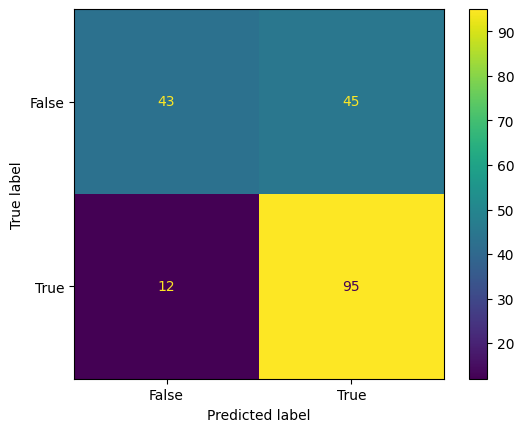

In [16]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[False, True])
cm_display.plot()
plt.show()